# `Рекуррентные Нейронные Сети. Dropout. LM

Данное задание будет состоять из двух частей:
1. Применение рекуррентной сети для решения задачи классификации текста. Более конкретно -- предсказания рейтинга отзыва фильма.
2. Простейшая лингвистическая модель для генерации текста на основе LSTM.

При выполнении задания вы обучите LSTM с разным уровнем "коробочности", а также познакомитесь с различными способами применения DropOut к рекуррентным архитектурам. В рекуррентных архитектурах вариантов, куда можно наложить бинарную маску шума, гораздо больше, чем в нейросетях прямого прохода.

Во второй части вы попробуете реализовать простейший рекуррентный декодер для генерации текстов.

# `Часть 0. Загрузка и предобработка данных (1 балл)`

In [1]:
max_length = 200
top_n_words = 5000

hidden_dim = 128
embedding_dim = 32

num_epochs = 15
batch_size = 64
learning_rate = 1e-3

Первое, что нужно сделать — скачать, предобработать данные и организовать их таким образом, чтобы их можно было подавать в нейронную сеть.

Для обеих частей задания мы будем использовать [**Large Movie Review Dataset**](https://ai.stanford.edu/~amaas/data/sentiment/).

## `Загрузка и предобработка данных`

Загрузите данные по ссылке выше. (**tip**: используйте `wget`)

In [2]:
! wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2023-04-19 15:23:52--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  15.4MB/s    in 8.9s    

2023-04-19 15:24:02 (9.07 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



Распакуйте скачанные данные в папку `aclImdb` (**tip:** используйте `tar`)

In [ ]:
! tar xvzf aclImdb_v1.tar.gz

In [ ]:
! apt install tree

In [5]:
! tree aclImdb -L 2

aclImdb
├── imdbEr.txt
├── imdb.vocab
├── README
├── test
│   ├── labeledBow.feat
│   ├── neg
│   ├── pos
│   ├── urls_neg.txt
│   └── urls_pos.txt
└── train
    ├── labeledBow.feat
    ├── neg
    ├── pos
    ├── unsup
    ├── unsupBow.feat
    ├── urls_neg.txt
    ├── urls_pos.txt
    └── urls_unsup.txt

7 directories, 11 files


Посмотрите в файле `./aclImdb/README` как организованы данные:

In [2]:
! cat ./aclImdb/train/pos/10000_8.txt

Homelessness (or Houselessness as George Carlin stated) has been an issue for years but never a plan to help those on the street that were once considered human who did everything from going to school, work, or vote for the matter. Most people think of the homeless as just a lost cause while worrying about things such as racism, the war on Iraq, pressuring kids to succeed, technology, the elections, inflation, or worrying if they'll be next to end up on the streets.<br /><br />But what if you were given a bet to live on the streets for a month without the luxuries you once had from a home, the entertainment sets, a bathroom, pictures on the wall, a computer, and everything you once treasure to see what it's like to be homeless? That is Goddard Bolt's lesson.<br /><br />Mel Brooks (who directs) who stars as Bolt plays a rich man who has everything in the world until deciding to make a bet with a sissy rival (Jeffery Tambor) to see if he can live in the streets for thirty days without th

In [3]:
test_data_path = './aclImdb/test/'
train_data_path = './aclImdb/train/'

In [4]:
import os
from functools import partial
from collections import defaultdict

import numpy as np

import torch
import torchtext
from torch.utils.data import DataLoader

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
from data import tokenize


tokenize('1. Hello <br /> words!! <br />')

['hello', 'words']

In [9]:
counter = defaultdict(int)

for path in ['./aclImdb/test/neg', './aclImdb/test/pos', './aclImdb/train/neg', './aclImdb/train/pos']:
    for file_path in os.listdir(path):
        text = open(os.path.join(path, file_path), 'r', encoding='utf-8', errors='ignore').read().strip()
        for token in tokenize(text):
            counter[token] += 1

In [10]:
n_show = 10
i_show = 0
for key, val in counter.items():
  print(f'{key:12}{val}')
  i_show += 1
  if i_show == n_show:
    break

never       12833
really      22899
started     1841
watching    8929
show        12028
canceled    119
showing     1576
reruns      120
actually    8364
enjoyed     2401


Для работы с текстами нам необходимо зарезервировать два специальных токена:
1. `<pad>` для токена означающего паддинг
2. `<unk>` для токенов, которые отсутствуют в словаре

In [11]:
specials = ['<pad>', '<unk>']

In [12]:
# create vocab from dict `counter`
vocab = torchtext.vocab.vocab(counter, min_freq=130, specials=specials)
vocab.set_default_index(vocab['<unk>'])

In [13]:
vocab.lookup_indices(['<pad>', '<unk>'])

[0, 1]

In [14]:
vocab.lookup_indices(['this', 'film', 'was', 'awful'])

[1, 93, 1, 218]

In [15]:
# size of vocab
print(
    f'recommended size: {top_n_words}',
    f'actual size: {len(vocab)}',
    sep='\n'
)

recommended size: 5000
actual size: 5435


Создайте датасеты для тестовой и обучающей выборки. 

Обратите внимание, что для задачи классификации нам не потребуется паддинг с помощью `<sos>`, `<eos>`. 

Не забудьте обрезать длинные тексты, передав параметр `max_length`.

In [18]:
from data import LargeMovieReviewDataset


train_dataset = LargeMovieReviewDataset(
    data_path='/content/aclImdb/train',
    vocab=vocab,
    max_len=max_length
)
test_dataset = LargeMovieReviewDataset(
    data_path='/content/aclImdb/test',
    vocab=vocab,
    max_len=max_length
)

Посмотрим, как выглядит объект в датасете:

In [19]:
test_dataset[0]

{'text': 'I never really started watching the show until it was canceled and started showing re-runs. I actually enjoyed it for the first to third season. Once I saw the fourth and fifth one I was beginning to get irate. The first problem was that they did that irrelevant, scenario of history repeating itself (Jr having a kid like his parents did). The second had to be the one where they had everyone paired up with someone (ex: Katie and franklin) . The third one was when they made Jr even more idiotic than before which was beginning to be tedious and vexing to the point where I wanted to go into the T.V. and beat the stupidity out of him until he\'s unconscious . The fourth one had to be that zealous dork that Clarie claimed as a boyfriend. The fifth one had to be Katie, she was beginning to be too good for herself and was treated her "boyfriend" Franklin like the pushover he was. The last but not least was Noah Gray-Cabey!! Franklin, Franklin was just scary. It was like watching a te

In [22]:
from functools import partial
from data import collate_fn


my_collate_fn = partial(collate_fn, padding_value=vocab['<pad>'], batch_first=False)

In [23]:
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=my_collate_fn,
    num_workers=2
)
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=my_collate_fn,
    num_workers=2
)

Посмотрим на какой-нибудь батч:

In [24]:
batch = next(iter(test_dataloader))
for key, val in batch.items():
  print(f'== {key} ==\n{val}\n')

== ratings ==
tensor([1, 0, 3, 0, 1, 0, 1, 0, 2, 3, 1, 1, 0, 3, 2, 2, 1, 2, 1, 3, 0, 1, 2, 0,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 3, 1, 1, 2, 0, 3, 0, 2, 3, 2, 3, 3, 0, 3, 1,
        3, 2, 0, 3, 2, 1, 1, 1, 0, 3, 3, 0, 0, 1, 1, 3])

== labels ==
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False])

== texts ==
['I never really started watching the show until it was canceled and started showing re-runs. I actually enjoyed it for the first to third season. Once I saw the fourth and fifth one I was beginning to get irate. The first problem was th

# `Часть 1. Классификация текстов (4 балла)`

## `Сборка и обучение RNN в pytorch (1 балл)`

In [25]:
# `all_results` map: method_name -> train_results
# `train_results` map:
#     'timer' -> int: time of 10 epochs training
#     'train_accuracy', 'test_accuracy' -> list: accuracies for each of 10 train epochs
#     'train_loss', 'test_loss' -> list: losses for each of 10 train epochs
all_results = {}

Создадим переменные для device-agnostic кода:

In [26]:
dtype, device, cuda_device_id = torch.float32, None, 0
os.environ["CUDA_VISIBLE_DEVICES"] = '{0}'.format(str(cuda_device_id) if cuda_device_id is not None else '')
if cuda_device_id is not None and torch.cuda.is_available():
    device = 'cuda:{0:d}'.format(0)
else:
    device = torch.device('cpu')
print(f'Using device: {device}, dtype: {dtype}')

Using device: cuda:0, dtype: torch.float32


Создадим модель классификации:

In [33]:
from lstm.model_clf import RNNClassifier


model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=torch.nn.LSTM, dropout=0
).to(device)

Создадим класс для подсчёта функции потерь и оптимизатор:

In [34]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Попробуем обучить модель:

In [ ]:
from time import time
from lstm.train_clf import train


start = time()
train_loss, train_accuracy, test_loss, test_accuracy = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
end = time()

Epoch: 1/15.	Loss (Train/Test): 0.784/2.018.	Accuracy (Train/Test): 0.711/0.363
Epoch: 2/15.	Loss (Train/Test): 0.708/2.088.	Accuracy (Train/Test): 0.750/0.364
Epoch: 3/15.	Loss (Train/Test): 0.617/2.216.	Accuracy (Train/Test): 0.792/0.359
Epoch: 4/15.	Loss (Train/Test): 0.575/2.365.	Accuracy (Train/Test): 0.808/0.347
Epoch: 5/15.	Loss (Train/Test): 0.477/2.500.	Accuracy (Train/Test): 0.852/0.353
Epoch: 6/15.	Loss (Train/Test): 0.421/2.671.	Accuracy (Train/Test): 0.870/0.355
Epoch: 7/15.	Loss (Train/Test): 0.388/2.816.	Accuracy (Train/Test): 0.885/0.339
Epoch: 8/15.	Loss (Train/Test): 0.294/2.942.	Accuracy (Train/Test): 0.925/0.343
Epoch: 9/15.	Loss (Train/Test): 0.261/3.090.	Accuracy (Train/Test): 0.935/0.347
Epoch: 10/15.	Loss (Train/Test): 0.255/3.166.	Accuracy (Train/Test): 0.939/0.335
Epoch: 11/15.	Loss (Train/Test): 0.202/3.336.	Accuracy (Train/Test): 0.955/0.339
Epoch: 12/15.	Loss (Train/Test): 0.147/3.540.	Accuracy (Train/Test): 0.975/0.338
Epoch: 13/15.	Loss (Train/Test): 0.13

In [ ]:
all_results['pure'] = {
    'timer': end - start,
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy,
    'train_loss': train_loss,
    'test_loss': test_loss
}

Нерегуляризованные LSTM часто быстро переобучаются (и мы это видим по точности на контроле). Чтобы с этим бороться, часто используют *L2-регуляризацию* и *дропаут*.
Однако способов накладывать дропаут на рекуррентный слой достаточно много, и далеко не все хорошо работают. По [ссылке](https://medium.com/@bingobee01/a-review-of-dropout-as-applied-to-rnns-72e79ecd5b7b) доступен хороший обзор дропаутов для RNN.

Мы реализуем два варианта DropOut для RNN (и третий дополнительно). Заодно увидим, что для реализации различных усовершенствований рекуррентной архитектуры приходится "вскрывать" слой до различной "глубины".

## `Реализация дропаута по статье Гала и Гарамани. Variational Dropout (1 балл)`

Начнем с дропаута, описанного в [статье Гала и Гарамани](https://arxiv.org/abs/1512.05287).
Для этого нам потребуется перейти от использования слоя `torch.nn.LSTM`, полностью скрывающего от нас рекуррентную логику, к использованию слоя `torch.nn.LSTMCell`, обрабатывающего лишь один временной шаг нашей последовательности (а всю логику вокруг придется реализовать самостоятельно). 

Допишите класс `RNNLayer`. При `dropout=0` ваш класс должен работать как обычный слой LSTM, а при `dropout > 0` накладывать бинарную маску на входной и скрытый вектор на каждом временном шаге, причем эта маска должна быть одинаковой во все моменты времени.

Дропаут Гала и Гарамани в виде формул (m обозначает маску дропаута):

$$
h_{t-1} = h_{t-1}*m_h, \, x_t = x_t * m_x
$$

Далее обычный шаг рекуррентной архитектуры, например, LSTM:

$$
i = \sigma(h_{t-1}W^i + x_t U^i+b_i) \quad
o = \sigma(h_{t-1}W^o + x_t U^o+b_o) 
$$
$$
f = \sigma(h_{t-1}W^f + x_t U^f+b_f) \quad 
g = tanh(h_{t-1} W^g + x_t U^g+b_g) 
$$
$$
c_t = f \odot c_{t-1} +  i \odot  g \quad
h_t =  o \odot tanh(c_t)
$$

In [38]:
from lstm.model_clf import RNNLayer


model = RNNClassifier(
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    output_size=10,
    vocab=vocab,
    rec_layer=RNNLayer,
).to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
start = time()
train_loss, train_accuracy, test_loss, test_accuracy = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
end = time()

Epoch: 1/15.	Loss (Train/Test): 1.941/1.953.	Accuracy (Train/Test): 0.273/0.276
Epoch: 2/15.	Loss (Train/Test): 1.755/1.784.	Accuracy (Train/Test): 0.334/0.329
Epoch: 3/15.	Loss (Train/Test): 1.603/1.663.	Accuracy (Train/Test): 0.380/0.356
Epoch: 4/15.	Loss (Train/Test): 1.517/1.604.	Accuracy (Train/Test): 0.406/0.381
Epoch: 5/15.	Loss (Train/Test): 1.454/1.582.	Accuracy (Train/Test): 0.433/0.386
Epoch: 6/15.	Loss (Train/Test): 1.389/1.574.	Accuracy (Train/Test): 0.452/0.391
Epoch: 7/15.	Loss (Train/Test): 1.337/1.564.	Accuracy (Train/Test): 0.479/0.391
Epoch: 8/15.	Loss (Train/Test): 1.282/1.593.	Accuracy (Train/Test): 0.493/0.397
Epoch: 9/15.	Loss (Train/Test): 1.214/1.610.	Accuracy (Train/Test): 0.528/0.387
Epoch: 10/15.	Loss (Train/Test): 1.156/1.664.	Accuracy (Train/Test): 0.550/0.383
Epoch: 11/15.	Loss (Train/Test): 1.067/1.696.	Accuracy (Train/Test): 0.591/0.378
Epoch: 12/15.	Loss (Train/Test): 1.003/1.804.	Accuracy (Train/Test): 0.615/0.377
Epoch: 13/15.	Loss (Train/Test): 0.91

In [ ]:
all_results['var_drop'] = {
    'timer': end - start,
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy,
    'train_loss': train_loss,
    'test_loss': test_loss
}

In [ ]:
model = RNNClassifier(
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    output_size=10,
    vocab=vocab,
    rec_layer=RNNLayer,
    dropout=0.25
).to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
start = time()
train_loss, train_accuracy, test_loss, test_accuracy = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
end = time()

Epoch: 1/15.	Loss (Train/Test): 2.022/2.022.	Accuracy (Train/Test): 0.223/0.226
Epoch: 2/15.	Loss (Train/Test): 2.006/2.011.	Accuracy (Train/Test): 0.226/0.234
Epoch: 3/15.	Loss (Train/Test): 1.748/1.767.	Accuracy (Train/Test): 0.344/0.342
Epoch: 4/15.	Loss (Train/Test): 1.647/1.683.	Accuracy (Train/Test): 0.361/0.358
Epoch: 5/15.	Loss (Train/Test): 1.584/1.633.	Accuracy (Train/Test): 0.389/0.376
Epoch: 6/15.	Loss (Train/Test): 1.551/1.620.	Accuracy (Train/Test): 0.396/0.380
Epoch: 7/15.	Loss (Train/Test): 1.495/1.579.	Accuracy (Train/Test): 0.416/0.392
Epoch: 8/15.	Loss (Train/Test): 1.464/1.558.	Accuracy (Train/Test): 0.421/0.395
Epoch: 9/15.	Loss (Train/Test): 1.432/1.538.	Accuracy (Train/Test): 0.437/0.404
Epoch: 10/15.	Loss (Train/Test): 1.416/1.534.	Accuracy (Train/Test): 0.446/0.404
Epoch: 11/15.	Loss (Train/Test): 1.385/1.524.	Accuracy (Train/Test): 0.453/0.405
Epoch: 12/15.	Loss (Train/Test): 1.371/1.520.	Accuracy (Train/Test): 0.459/0.409
Epoch: 13/15.	Loss (Train/Test): 1.35

In [ ]:
all_results['var_drop0.25'] = {
    'timer': end - start,
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy,
    'train_loss': train_loss,
    'test_loss': test_loss
}

## `Реализация дропаута по статье Гала и Гарамани. Дубль 2 (1 балл)`

<начало взлома pytorch>

При разворачивании цикла по времени средствами python обучение рекуррентной нейросети сильно замедляется. Однако для реализации дропаута Гала и Гарамани необязательно явно задавать в коде умножение нейронов на маски. Можно схитрить и обойтись использованием слоя `torch.nn.LSTM`: перед вызовом `forward` слоя `torch.nn.LSTM` подменять его веса на веса, домноженные по строкам на маски. А обучаемые веса хранить отдельно. Именно так этот дропаут реализован в библиотеке `fastai`, код из которой использован в ячейке ниже.

Такой слой реализуется в виде обертки над `torch.nn.LSTM`. Допишите класс:

In [41]:
from lstm.model_clf import FastRNNLayer


model = RNNClassifier(
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    output_size=10,
    vocab=vocab,
    # the only thing changed since the last experiment
    rec_layer=FastRNNLayer,
).to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
start = time()
train_loss, train_accuracy, test_loss, test_accuracy = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
end = time()

Epoch: 1/15.	Loss (Train/Test): 1.986/1.989.	Accuracy (Train/Test): 0.244/0.242
Epoch: 2/15.	Loss (Train/Test): 1.773/1.791.	Accuracy (Train/Test): 0.334/0.336
Epoch: 3/15.	Loss (Train/Test): 1.695/1.729.	Accuracy (Train/Test): 0.354/0.353
Epoch: 4/15.	Loss (Train/Test): 1.612/1.678.	Accuracy (Train/Test): 0.371/0.353
Epoch: 5/15.	Loss (Train/Test): 1.504/1.595.	Accuracy (Train/Test): 0.406/0.376
Epoch: 6/15.	Loss (Train/Test): 1.438/1.581.	Accuracy (Train/Test): 0.433/0.387
Epoch: 7/15.	Loss (Train/Test): 1.400/1.563.	Accuracy (Train/Test): 0.449/0.394
Epoch: 8/15.	Loss (Train/Test): 1.343/1.561.	Accuracy (Train/Test): 0.470/0.387
Epoch: 9/15.	Loss (Train/Test): 1.304/1.566.	Accuracy (Train/Test): 0.491/0.389
Epoch: 10/15.	Loss (Train/Test): 1.251/1.600.	Accuracy (Train/Test): 0.507/0.385
Epoch: 11/15.	Loss (Train/Test): 1.237/1.672.	Accuracy (Train/Test): 0.512/0.395
Epoch: 12/15.	Loss (Train/Test): 1.121/1.659.	Accuracy (Train/Test): 0.566/0.384
Epoch: 13/15.	Loss (Train/Test): 1.05

In [ ]:
all_results['var_drop_v2'] = {
    'timer': end - start,
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy,
    'train_loss': train_loss,
    'test_loss': test_loss
}

In [ ]:
model = RNNClassifier(
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    output_size=10,
    vocab=vocab,
    rec_layer=FastRNNLayer,
    dropout=0.25
).to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
start = time()
train_loss, train_accuracy, test_loss, test_accuracy = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
end = time()

Epoch: 1/15.	Loss (Train/Test): 1.999/2.006.	Accuracy (Train/Test): 0.232/0.229
Epoch: 2/15.	Loss (Train/Test): 1.882/1.900.	Accuracy (Train/Test): 0.305/0.309
Epoch: 3/15.	Loss (Train/Test): 1.729/1.758.	Accuracy (Train/Test): 0.349/0.349
Epoch: 4/15.	Loss (Train/Test): 1.626/1.673.	Accuracy (Train/Test): 0.369/0.358
Epoch: 5/15.	Loss (Train/Test): 1.580/1.635.	Accuracy (Train/Test): 0.385/0.371
Epoch: 6/15.	Loss (Train/Test): 1.542/1.610.	Accuracy (Train/Test): 0.398/0.370
Epoch: 7/15.	Loss (Train/Test): 1.491/1.571.	Accuracy (Train/Test): 0.412/0.390
Epoch: 8/15.	Loss (Train/Test): 1.476/1.567.	Accuracy (Train/Test): 0.424/0.392
Epoch: 9/15.	Loss (Train/Test): 1.436/1.547.	Accuracy (Train/Test): 0.434/0.394
Epoch: 10/15.	Loss (Train/Test): 1.412/1.542.	Accuracy (Train/Test): 0.440/0.403
Epoch: 11/15.	Loss (Train/Test): 1.387/1.532.	Accuracy (Train/Test): 0.451/0.403
Epoch: 12/15.	Loss (Train/Test): 1.369/1.522.	Accuracy (Train/Test): 0.458/0.408
Epoch: 13/15.	Loss (Train/Test): 1.35

In [ ]:
all_results['var_drop_v2_0.25'] = {
    'timer': end - start,
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy,
    'train_loss': train_loss,
    'test_loss': test_loss
}

</конец взлома pytorch>

## `Реализация дропаута по статье Семениуты и др. (1 балл)`

Перейдем к реализации дропаута для LSTM по статье [Semeniuta et al](http://www.aclweb.org/anthology/C16-1165). 

Этот метод применения дропаута не менее популярен, чем предыдущий. Его особенность состоит в том, что он придуман специально для гейтовых архитектур. В контексте LSTM этот дропаут накладывается только на информационный поток ($m_h$ — маска дропаута):
$$
i = \sigma(h_{t-1}W^i + x_t U^i+b_i) \quad
o = \sigma(h_{t-1}W^o + x_t U^o+b_o) 
$$
$$
f = \sigma(h_{t-1}W^f + x_t U^f+b_f) \quad 
g = tanh(h_{t-1} W^g + x_t U^g+b_g) 
$$
$$
c_t = f \odot c_{t-1} +  i \odot g \odot {\bf m_h} \quad
h_t =  o \odot tanh(c_t)
$$
На входы $x_t$ маска накладывается как в предыдущем дропауте. Впрочем, на входы маску можно наложить вообще до вызова рекуррентного слоя.

Согласно статье, маска дропаута может быть как одинаковая, так и разная для всех моментов времени. Мы сделаем одинаковую для всех моментов времени.

Для реализации этого дропаута можно: 
1. самостоятельно реализовать LSTM (интерфейса LSTMCell не хватит) 
2. снова воспользоваться трюком с установкой весов (но тут мы опираемся на свойство $tanh(0)=0$, к тому же, трюк в данном случае выглядит менее тривиально, чем с дропаутом Гала). 

Предлагается реализовать дропаут по сценарию 1. Допишите класс:

In [43]:
from lstm.model_clf import HandmadeLSTM


model = RNNClassifier(
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    output_size=10,
    vocab=vocab,
    # the only thing changed since the last  experiment
    rec_layer=HandmadeLSTM,
).to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
start = time()
train_loss, train_accuracy, test_loss, test_accuracy = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
end = time()

Epoch: 1/15.	Loss (Train/Test): 1.944/1.951.	Accuracy (Train/Test): 0.295/0.297
Epoch: 2/15.	Loss (Train/Test): 1.702/1.740.	Accuracy (Train/Test): 0.352/0.344
Epoch: 3/15.	Loss (Train/Test): 1.611/1.670.	Accuracy (Train/Test): 0.369/0.360
Epoch: 4/15.	Loss (Train/Test): 1.531/1.627.	Accuracy (Train/Test): 0.391/0.373
Epoch: 5/15.	Loss (Train/Test): 1.448/1.586.	Accuracy (Train/Test): 0.430/0.382
Epoch: 6/15.	Loss (Train/Test): 1.386/1.574.	Accuracy (Train/Test): 0.453/0.395
Epoch: 7/15.	Loss (Train/Test): 1.345/1.579.	Accuracy (Train/Test): 0.474/0.391
Epoch: 8/15.	Loss (Train/Test): 1.270/1.599.	Accuracy (Train/Test): 0.498/0.399
Epoch: 9/15.	Loss (Train/Test): 1.243/1.649.	Accuracy (Train/Test): 0.509/0.395
Epoch: 10/15.	Loss (Train/Test): 1.154/1.657.	Accuracy (Train/Test): 0.545/0.380
Epoch: 11/15.	Loss (Train/Test): 1.075/1.690.	Accuracy (Train/Test): 0.579/0.389
Epoch: 12/15.	Loss (Train/Test): 1.004/1.742.	Accuracy (Train/Test): 0.622/0.369
Epoch: 13/15.	Loss (Train/Test): 0.93

In [ ]:
all_results['drop_semen'] = {
    'timer': end - start,
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy,
    'train_loss': train_loss,
    'test_loss': test_loss
}

In [ ]:
model = RNNClassifier(
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    output_size=10,
    vocab=vocab,
    # the only thing changed since the last  experiment
    rec_layer=HandmadeLSTM,
    dropout=0.25
).to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
start = time()
train_loss, train_accuracy, test_loss, test_accuracy = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
end = time()

Epoch: 1/15.	Loss (Train/Test): 2.020/2.021.	Accuracy (Train/Test): 0.230/0.232
Epoch: 2/15.	Loss (Train/Test): 1.873/1.886.	Accuracy (Train/Test): 0.303/0.306
Epoch: 3/15.	Loss (Train/Test): 1.732/1.765.	Accuracy (Train/Test): 0.341/0.343
Epoch: 4/15.	Loss (Train/Test): 1.639/1.682.	Accuracy (Train/Test): 0.364/0.345
Epoch: 5/15.	Loss (Train/Test): 1.590/1.642.	Accuracy (Train/Test): 0.380/0.364
Epoch: 6/15.	Loss (Train/Test): 1.562/1.628.	Accuracy (Train/Test): 0.386/0.369
Epoch: 7/15.	Loss (Train/Test): 1.545/1.637.	Accuracy (Train/Test): 0.375/0.343
Epoch: 8/15.	Loss (Train/Test): 1.496/1.593.	Accuracy (Train/Test): 0.412/0.388
Epoch: 9/15.	Loss (Train/Test): 1.471/1.583.	Accuracy (Train/Test): 0.421/0.390
Epoch: 10/15.	Loss (Train/Test): 1.441/1.568.	Accuracy (Train/Test): 0.428/0.387
Epoch: 11/15.	Loss (Train/Test): 1.409/1.557.	Accuracy (Train/Test): 0.442/0.402
Epoch: 12/15.	Loss (Train/Test): 1.409/1.576.	Accuracy (Train/Test): 0.443/0.399
Epoch: 13/15.	Loss (Train/Test): 1.38

In [ ]:
all_results['drop_semen_0.25'] = {
    'timer': end - start,
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy,
    'train_loss': train_loss,
    'test_loss': test_loss
}

## `Сравнение всех предложенных моделей (1 балл)`

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

In [ ]:
%matplotlib inline

from IPython.display import set_matplotlib_formats

set_matplotlib_formats('pdf', 'svg')

<ipython-input-72-1d4f17c67935>:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


In [ ]:
colors = [
    'blue',
    'orange',
    'green',
    'red',
    'purple',
    'olive',
    'cyan'
]

In [ ]:
for method, dct in all_results.items():
  print(f'{method:15}', '\t', dct['timer'])

pure            	 179.48761129379272
var_drop        	 777.4700808525085
var_drop0.25    	 733.879453420639
var_drop_v2     	 169.80846571922302
var_drop_v2_0.25 	 172.6650242805481
drop_semen      	 1677.9954762458801
drop_semen_0.25 	 1622.1096217632294


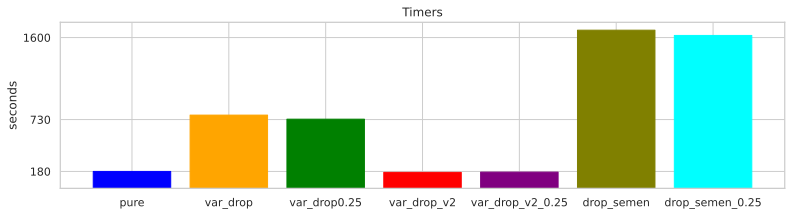

In [ ]:
plt.figure(figsize=(13, 3))
timers = []
labels = []
for method, train_res in all_results.items():
  timers.append(train_res['timer'])
  labels.append(method)

bars = plt.bar(x=range(len(timers)), height=timers)
plt.xticks(range(len(timers)), labels=labels)

for color, bar in zip(colors, bars):
  bar.set_color(color)

plt.yticks([180, 730, 1600])
plt.title('Timers')
plt.ylabel('seconds')
plt.show()

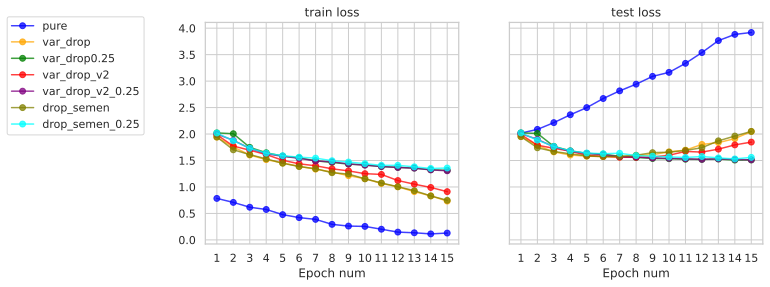

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True, sharex=True)

for i, (method, train_res) in enumerate(all_results.items()):
  # loss
  ax[0].plot(train_res['train_loss'], label=f'{method}', color=colors[i], alpha=0.75, marker='o')
  ax[1].plot(train_res['test_loss'], color=colors[i], alpha=0.75, marker='o')

  ax[0].set_title('train loss')
  ax[1].set_title('test loss')

ax[0].legend(bbox_to_anchor=(-0.22, 1.05))
ax[0].set_xticks(range(15), labels=range(1,16))
ax[0].set_xlabel('Epoch num')
ax[1].set_xlabel('Epoch num')
plt.show()

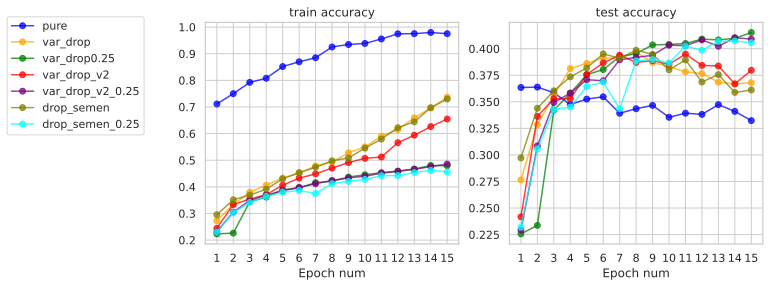

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=False, sharex=True)

for i, (method, train_res) in enumerate(all_results.items()):
  # loss
  ax[0].plot(train_res['train_accuracy'], label=f'{method}', color=colors[i], alpha=0.75, marker='o')
  ax[1].plot(train_res['test_accuracy'], color=colors[i], alpha=0.75, marker='o')

  ax[0].set_title('train accuracy')
  ax[1].set_title('test accuracy')

ax[0].legend(bbox_to_anchor=(-0.22, 1.05))
ax[0].set_xticks(range(15), labels=range(1,16))
ax[0].set_xlabel('Epoch num')
ax[1].set_xlabel('Epoch num')
plt.show()

Сделайте итоговые выводы о качестве работы моделей с разными реализациями DropOut:

**Ответ:**
1. дропаут действительно уменьшает переобучение:
  - LSTM без него (график `pure`) на обучении дает accuracy выше (и loss ниже) чем любая другая модель, причем с большим отрывом
  - все версии дропаута дают accuracy на тесте примерно 0.41, в то время как все версии без дропаута достигают около 0.39 в середине обучения и затем падают до около 0.36
2. лидерборд по скорости работы:
  1. `pure`, `var_drop_v2`, `var_drop_v2_0.25`
  2. `var_drop`, `var_drop0.25`
  3. `drop_semen`, `drop_semen_0.25`

  Учитывая, что все дропауты дают примерно одинаковое качество, можно сказать, что эффективнее всего использование вариационного дропаута с обнулением весов модели.

# `Часть 2. Language Modeling с помощью LSTM (5 баллов)`

## `Реализация модели и цикла обучения (2 балла)`

**Не используйте циклы в `RNNLM`, `LMCrossEntropyLoss`, `LMAccuracy`**

In [48]:
specials = ['<pad>', '<unk>', '<sos>', '<eos>']
lm_vocab = torchtext.vocab.vocab(counter, specials=specials, special_first=True, min_freq=4)
lm_vocab.set_default_index(lm_vocab['<unk>'])

In [49]:
len(lm_vocab)

49943

In [50]:
lm_test_dataset = LargeMovieReviewDataset(test_data_path, lm_vocab, max_len=20, pad_sos=True, pad_eos=True)
lm_train_dataset = LargeMovieReviewDataset(train_data_path, lm_vocab, max_len=20, pad_sos=True, pad_eos=True)

In [51]:
lm_test_dataloader = DataLoader(
    lm_test_dataset, batch_size=96, shuffle=False, num_workers=2, 
    collate_fn=partial(collate_fn, padding_value=lm_vocab.lookup_indices(['<pad>'])[0])
)
lm_train_dataloader = DataLoader(
    lm_train_dataset, batch_size=96, shuffle=True, num_workers=2, 
    collate_fn=partial(collate_fn, padding_value=lm_vocab.lookup_indices(['<pad>'])[0])
)

Убедитесь, что все предложения имеют в начале `<sos>` токен, а в конце — `<eos>` токен.

In [52]:
batch = next(iter(lm_train_dataloader))
batch['tokens'], batch['tokens_lens']

(tensor([[    2,     2,     2,  ...,     2,     2,     2],
         [28986,   114,  4323,  ..., 28870,   114,    17],
         [28987,     1, 49021,  ...,     1,  2104,   114],
         ...,
         [  114,  8090, 24678,  ...,   162,   242,  1041],
         [   31,  5052, 48903,  ..., 24938,  1784,  4456],
         [    3,     3,     3,  ...,     3,     3,     3]]),
 tensor([20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20]))

Создадим модель, функцию потерь и оптимизатор: 

In [53]:
from lstm.model_lm import RNNLM


lm_model = RNNLM(
    embedding_dim=512, hidden_dim=512, vocab=lm_vocab, dropout=0.6, layers_dropout=0.6, num_layers=2
).to(device=device)

In [54]:
from lstm.model_lm import LMCrossEntropyLoss


lm_loss_fn = LMCrossEntropyLoss(reduction='mean')
lm_optimizer = torch.optim.Adam(lm_model.parameters(), lr=0.005, weight_decay=1.2e-6)

Обучим модель:

In [55]:
from lstm.train_lm import train_lm


lm_train_losses, lm_train_accuracies, lm_test_losses, lm_test_accuracies = train_lm(
    lm_train_dataloader, lm_test_dataloader, lm_model, lm_loss_fn, lm_optimizer, device, 10
)

Epoch: 1/10. Loss (Train/Test): 7.672/7.808. Accuracy (Train/Test): 0.075/0.075
Epoch: 2/10. Loss (Train/Test): 7.437/7.661. Accuracy (Train/Test): 0.084/0.084
Epoch: 3/10. Loss (Train/Test): 7.220/7.546. Accuracy (Train/Test): 0.089/0.088
Epoch: 4/10. Loss (Train/Test): 7.011/7.475. Accuracy (Train/Test): 0.094/0.092
Epoch: 5/10. Loss (Train/Test): 6.821/7.444. Accuracy (Train/Test): 0.098/0.096
Epoch: 6/10. Loss (Train/Test): 6.657/7.450. Accuracy (Train/Test): 0.103/0.098
Epoch: 7/10. Loss (Train/Test): 6.457/7.441. Accuracy (Train/Test): 0.106/0.099
Epoch: 8/10. Loss (Train/Test): 6.294/7.458. Accuracy (Train/Test): 0.111/0.100
Epoch: 9/10. Loss (Train/Test): 6.136/7.485. Accuracy (Train/Test): 0.114/0.101
Epoch: 10/10. Loss (Train/Test): 5.991/7.523. Accuracy (Train/Test): 0.120/0.102


## `Реализация декодера (1 балл)`

Теперь, реализуем последнюю деталь — декодирование с использованием обученной модели.
Есть несколько вариантов. Рассмотрим два самых простых:
1. **Жадное декодирование.** На каждом шаге мы выбираем токен с максимальной вероятностью и используем его для обновления скрытого состояния RNN.
2. **Top-k sampling.** На очередном шаге рассматриваются $k$ токенов с самыми большими вероятностями. Остальные токены игнорируются. Из выбранных токенов семплируется следующий токен пропорционально их вероятностям.

Прочитать подробнее про разные варианты декодирования можно по ссылкам:
1. [От huggingface](https://huggingface.co/blog/how-to-generate)
2. [На towardsdatascience](https://towardsdatascience.com/decoding-strategies-that-you-need-to-know-for-response-generation-ba95ee0faadc)

Существенным в процессе декодирования является критерий останова. Как только очередной самый вероятный символ оказался `<eos>`, то данная последовательность считается сгенерированной. Однако, может так оказаться, что `<eos>` никогда не будет выбран, тогда необходимо прекратить генерацию, как только длина последовательности перейдёт порог `max_generated_len`.

In [62]:
start_tokens = torch.tensor([
    lm_model.vocab.lookup_indices(['<sos>', '<pad>', '<pad>', '<pad>']),
    lm_model.vocab.lookup_indices(['<sos>', 'my', 'favorite', 'movie']),
    lm_model.vocab.lookup_indices(['<sos>', 'the', 'best', 'movie']),
    lm_model.vocab.lookup_indices(['<sos>', 'the', 'worst', 'movie']),
    lm_model.vocab.lookup_indices(['<sos>', 'authors', 'bless', 'film']),
]).T

start_tokens_lens = torch.tensor([1, 4, 4, 4, 4])

In [63]:
lm_model = lm_model.cpu()
lm_model.eval()

RNNLM(
  (vocab): Vocab()
  (word_embeddings): Embedding(49943, 512, padding_idx=0)
  (rnn): FastRNNLayer(
    (module): LSTM(512, 512, num_layers=2, dropout=0.6)
  )
  (output): Linear(in_features=512, out_features=49943, bias=True)
)

In [ ]:
def show_decoded():
  global decoded_tokens, start_tokens, decoded_lens, start_tokens_lens
  global lm_model
  for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

Попробуйте выполнить семплирование для разных $k$. Сравните результаты top-k семплирования с жадным декодированием. Опишите ваши наблюдения.

**greedy:**
- никакого смысла, но есть фразы из двух слов (`bad acting`, `bad script`)
- слова просто повторяются либо предложение быстро заканчивается
- все отзывы негативные

In [ ]:
from model_lm import decode


decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=20)
show_decoded()

<sos> movie bad acting bad acting bad acting bad directing bad acting bad script bad acting bad script bad script bad
<sos> <unk> favorite movie ever seen movie <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
<sos> <unk> best movie ever seen movie <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
<sos> <unk> worst movie ever seen life movie ever seen movie bad acting bad acting bad acting bad script bad acting bad acting bad
<sos> authors bless film <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>


**k=1:**
- такой же результат, что и greedy, потому что эквивалентные методы

In [ ]:
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=1)
show_decoded()

<sos> movie bad acting bad acting bad acting bad directing bad acting bad script bad acting bad script bad script bad
<sos> <unk> favorite movie ever seen movie <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
<sos> <unk> best movie ever seen movie <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
<sos> <unk> worst movie ever seen life movie ever seen movie bad acting bad acting bad acting bad script bad acting bad acting bad
<sos> authors bless film <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>


**k=2:**
- никакого смысла, но добавились фразы (`terrible directing`, `good music`, `good acting`)
- слова повторяются, но добавилось пару слов (`terrible`, `music` и т.д.)
- предложения стали подлиннее
- появился положительный отзыв (третий)

In [ ]:
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=2)
show_decoded()

<sos> movie bad bad acting bad acting bad script bad script bad acting terrible directing bad script bad acting bad acting
<sos> <unk> favorite movie ever seen movie <unk> movie made movie <unk> <unk> <unk> <unk> movie <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
<sos> <unk> best movie ever made movie made one best movies ever made movie made movie good acting good music good music movie great
<sos> <unk> worst movie ever seen movie bad acting terrible acting terrible script bad acting bad script terrible script bad script terrible acting bad
<sos> authors bless film <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>


**k=3**
- слова повторяются
- добавились еще слова и фразы (`great story`)
- теперь полтора положительных отзыва (в третьем отзыве повторяются сначала положительные слова, затем негативные) 

In [ ]:
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=3)
show_decoded()

<sos> movie great cast good acting good acting great directing great music great actors great music movie great story great characters
<sos> <unk> favorite movie ever seen movie <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> movie <unk> movie <unk> <unk>
<sos> <unk> best movie ever seen movie saw movie theater movie really good one worst movies ever seen movie bad acting terrible acting bad
<sos> <unk> worst movie ive ever seen movie bad acting terrible script horrible acting bad script bad writing bad acting terrible writing bad acting
<sos> authors bless film one worst films ever seen life film <unk> <unk> <unk> <unk> <unk> <unk> <unk> one <unk> film <unk> <unk> <unk>


**k=4**
- почти нет изменений

In [ ]:
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=4)
show_decoded()

<sos> movie starts <unk> <unk> one worst films ever displeasure money movie ever seen life movie bad movie one bad movies
<sos> <unk> favorite movie ever seen <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> film made film noir story line brilliantly acted <unk>
<sos> <unk> best movie ever seen movie saw movie years ago saw first time ago saw first time saw trailer thought id never heard
<sos> <unk> worst movie ever seen life <unk> acting bad directing bad effects bad script bad script bad acting wooden directing bad writing bad
<sos> authors bless film directed <unk> one best <unk> films ive ever seen film seen years later <unk> <unk> <unk> <eos>


**k=5**
- появились фразы по четыре слова (`saw film years ago` и т.д.)

In [ ]:
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=5)
show_decoded()

<sos> first saw film tonight saw film years ago saw recently got chance see one best film ive ever seen film
<sos> <unk> favorite movie ever made great acting cinematography cinematography good music movie really bad acting wasnt good story line movie <eos>
<sos> <unk> best movie ive seen years years ago watched first time ago first time movie started saw trailer first half hour hour movie
<sos> <unk> worst movie ever seen movie bad acting awful bad acting poor acting terrible acting bad writing bad acting terrible script terrible directing
<sos> authors bless film opens woman artemisia gentileschi <unk> <unk> <unk> one best examples ever seen film <unk> one remaining <unk> <unk> <eos>


**k=10**
- в первом отзыве есть смысл!

In [ ]:
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=10)
show_decoded()

<sos> movie awesome one favorite movies ever made <unk> movie one better acting <unk> <unk> plot ridiculous special effects <unk> <eos>
<sos> <unk> favorite movie ever seen one movies one worst movie ever seen one <unk> acting good movie bad acting terrible acting bad direction
<sos> <unk> best movie ever seen <unk> saw movie really bad good bad <unk> movies like movies like movie one <eos>
<sos> <unk> worst movie ever seen dont know much one best thing ever made movie <unk> acting terrible direction directing cinematography directing story <eos>
<sos> authors bless film student <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> made much better film one greatest films year later


**k=100**
- меньше символов unk
- фразы пропали


In [ ]:
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=100)
show_decoded()

<sos> ive long time enjoyed recently viewing watched really liked first aired series trailer saw last year old vhs back could
<sos> <unk> favorite movie actually <unk> <unk> made sappy ridiculous performance like good movie didnt turn hollywood made <eos>
<sos> <unk> best movie movie ever seen entire family made actors like <unk> feel wrong <unk> dont know money like <eos>
<sos> <unk> worst movie ever seen ever seen <unk> films great part however many films director <unk> one good times also <eos>
<sos> authors bless film film suffers quite poor production values film features great job film based novel feel film set studio <eos>


**k=1000**
- unk еще меньше
- фразы совсем пропали


In [ ]:
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=1000)
show_decoded()

<sos> whats best movie ever seen dvd times thanks laugh got us way anyway got took place book allowed television copy
<sos> <unk> favorite movie would like fairly bad premise even worse film theres stupid given one young men mike harlin <eos>
<sos> <unk> best movie let isnt mean one movies id give one worst movies ever made acting lifeless classic wrong enough cant believe story
<sos> <unk> worst movie seen maybe martin poseys great story roles lines one worst films ever scene youre afraid <unk> gives thing us <eos>
<sos> authors bless film simply never one late footage <unk> george cusack gets older house late <unk> paltrow cast conflicted drifter order confront <eos>


**Ответ:**
жадное декодирование ($\iff k=1$) и $k\gg1$ являются двумя крайностями: при малом $k$ предложения короткие и используют мало слов, при большом $k$ предложения большие и используют самые разнообразные слова, золотая середина соответствует длинным предложениям с фразами из 3-5 слов и практически без повторений слов
